# Ultimate Challenge Mini-Proj

## Part 1 - Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15 minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

In [2]:
file = 'logins.json'
f = open(file)
logins = json.loads(f.read())
f.close()

#### Examine login_time_by inspecting data

In [3]:
logins.keys()

dict_keys(['login_time'])

In [4]:
print(len(logins['login_time']))

93142


In [5]:
#create dataframe
df_logins = pd.DataFrame(pd.to_datetime(logins['login_time']),columns=['login_time'])
df_logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [6]:
#check for na values
df_logins[df_logins['login_time'].isna()].shape

(0, 1)

In [7]:
df_logins.isnull().sum()

login_time    0
dtype: int64

In [8]:
#add count column for resample
df_logins['count'] = 1

In [9]:
df_logins.head()

,login_time,count
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


In [10]:
#set login time as index for resampling
df_logins.index = df_logins['login_time']

In [11]:
df_logins.head()

,login_time,count
login_time,,
1970-01-01 20:13:18,1970-01-01 20:13:18,1
1970-01-01 20:16:10,1970-01-01 20:16:10,1
1970-01-01 20:16:37,1970-01-01 20:16:37,1
1970-01-01 20:16:36,1970-01-01 20:16:36,1
1970-01-01 20:26:21,1970-01-01 20:26:21,1


In [12]:
df_logins = df_logins.drop(['login_time'], axis=1)

In [13]:
df_logins.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


<AxesSubplot:xlabel='login_time'>

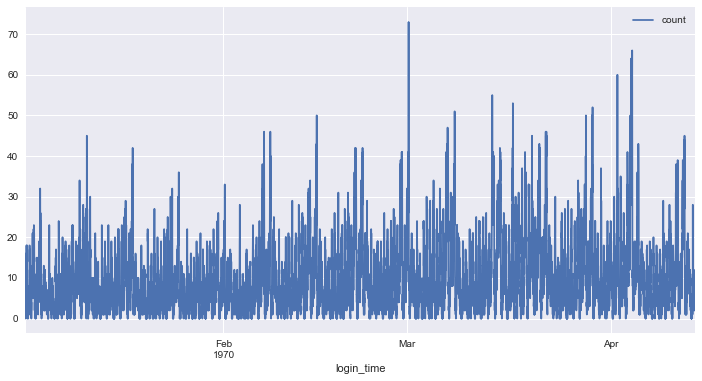

In [14]:
df_count = df_logins.resample('15min').sum()
df_count.plot(kind='line',figsize=(12,6))

Note: Plotting the 15 minute intervals over the 1 quarter of the year 1970, the average demand in the pattern is increasing slightly.

In [15]:
df_count.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


Note: The average number of logins per 15 minutes intervals is 7% with a spike of 9.5%

#### Day distributions

In [16]:
#create two columns to analyze daily week cycles
df_count = df_count.assign(month_day=df_count.index.day)
df_count = df_count.assign(weekday=df_count.index.weekday)
df_count.head(7)

,count,month_day,weekday
login_time,,,
1970-01-01 20:00:00,2,1,3
1970-01-01 20:15:00,6,1,3
1970-01-01 20:30:00,9,1,3
1970-01-01 20:45:00,7,1,3
1970-01-01 21:00:00,1,1,3
1970-01-01 21:15:00,4,1,3
1970-01-01 21:30:00,0,1,3


Note: The daily logins per weekday.

### Data Visualization

<AxesSubplot:xlabel='login_time'>

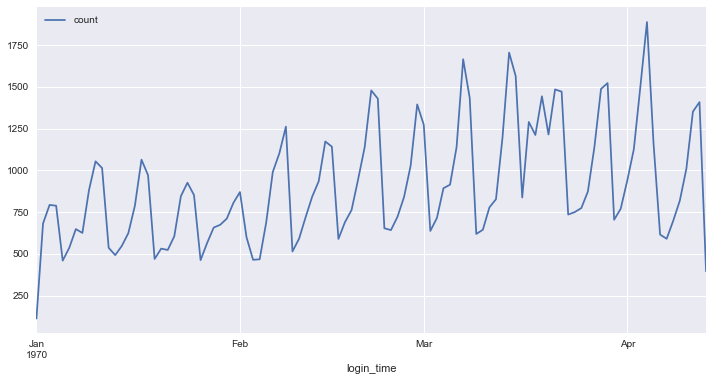

In [17]:
#resample daily frequency
df_day = df_logins.resample('1D').sum()
df_day.plot(kind='line',figsize=(12,6))

Note: Resampling to daily frequency shows there is an increasing trend of the average number of logins. In the month of January, there seems to be very little change in the average number of daily logins, however february is when the increasing trend begins. 

Text(0.5, 6.799999999999994, 'Day')

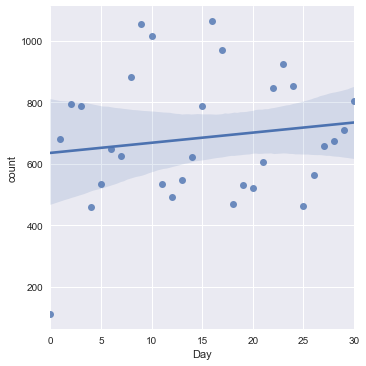

In [18]:
#January trend
plot_df = df_day[df_day.index.month==1]
plot_df = plot_df.assign(x = range(plot_df.shape[0]))
sns.lmplot(data=plot_df,x='x',y='count')
plt.xlabel('Day')

Text(0.5, 6.799999999999994, 'Day')

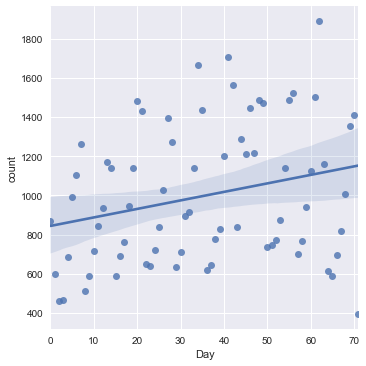

In [19]:
#Feb - April trend
plot_df = df_day[df_day.index.month >1]
plot_df = plot_df.assign(x = range(plot_df.shape[0]))
sns.lmplot(data=plot_df,x='x',y='count')
plt.xlabel('Day')

Note: Comfirming the upward trend of daily logins gradually occuring feb thru April

## Part 2 ‐ Experiment and metrics design

*The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

*However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

*1) What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

*2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

**a) how you will implement the experiment

**b) what statistical test(s) you will conduct to verify the significance of the observation

**c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

**Note: The two cities of Gotham and Metropolis are not in the provided dataset; however, you do
not need this information to answer Part 2.

##### Answer #1 -

I would choose AB frequentist testing because I would want to measure the causal effect difference between Gotham and Metropolis groups statistically at some significance level.

##### Answer #2 A- 

**There are 5 steps to AB Testing Approach.

**1.	Setting hypotheses - (to determine if we can or cannot reject the null)

**2.	Getting baseline numbers for metrics - (Given enough sample size, we will usually be able to find a statistically significant difference between two groups)

**3.	Minimum Detectable Effect (MDE)

**4.	Power Analysis (To determine the sample size required to conclude an experiment)

**5.	Estimate duration of the experiment

**6.	Discuss with stakeholders

Depending on the type of metric we choose we might use a different statistical test however the approach is t-tests for starters.

#### Answer#2B -

Null-hypotheses statistical testing on a predetermine sample size for the test and a stopping point (when the test will end), will likely yield accurate results.

##### Answer#2C -

***When interpreting the results of the A/B test and provide recommendations, there is a validity checklist that needs to happen to avoid false positives or statistical error. 

***These factors include: 

**Sample Size 

**Significance level 

**Test duration

**Number of conversions 

**Analyze external and internal factors 

**Segmenting test results (the type of visitor, traffic, and device) 

**Analyzing micro-conversion data

When interpreting the results of an A/B test, it’s not always about looking for a variation that had more conversions, but  about learning the changes in user behavior between Gotham and Metropolis. My recommendation is always be constantly testing so as to understand the behaviors and the elements that influence change. 

## Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

In [20]:
#import data from json file
file = 'ultimate_data_challenge.json'
with open(file) as f:
    data = json.loads(f.read())
df = pd.DataFrame(data)

## Data Description

**● city: city this user signed up in

**● phone: primary device for this user

**● signup_date: date of account registration; in the form ‘YYYYMMDD’

**● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

**● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

**● avg_rating_by_driver: the rider’s average rating over all of their trips

**● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

**● surge_pct: the percent of trips taken with surge multiplier > 1

**● avg_surge: The average surge multiplier over all of this user’s trips

**● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

**● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE
otherwise

**● weekday_pct: the percent of the user’s trips occurring during a weekday

In [21]:
df.head(10)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,True,100.0,10.56,5.0
6,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,Android,0.0,False,100.0,3.95,4.0
7,Winterfell,2,2014-01-28,5.0,1.00,2014-01-29,iPhone,0.0,False,100.0,2.04,5.0
8,Winterfell,2,2014-01-21,4.5,1.00,2014-02-01,Android,0.0,False,100.0,4.36,5.0
9,Winterfell,1,2014-01-03,NaN,1.00,2014-01-05,Android,0.0,False,0.0,2.37,5.0


In [22]:
#inspect dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


### Cleaning Dataset

#### Number of Missing Values By Column

In [23]:
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count')

,count,%
city,0,0.000
trips_in_first_30_days,0,0.000
signup_date,0,0.000
avg_surge,0,0.000
last_trip_date,0,0.000
surge_pct,0,0.000
ultimate_black_user,0,0.000
weekday_pct,0,0.000
avg_dist,0,0.000
avg_rating_by_driver,201,0.402


Note: avg_rating_of_driver has the most missing values, at just over 16%. Phone and avg_rating_by_driver is missing values from 8% and 4%.

In [24]:
#drop rows with no phone information
df = df.drop(df[df.phone.isna()==True].index,axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    41578 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49406 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


#### Examine columns

In [25]:
df['avg_rating_by_driver'].describe()

count    49406.000000
mean         4.777861
std          0.447114
min          1.000000
25%          4.700000
50%          5.000000
75%          5.000000
max          5.000000
Name: avg_rating_by_driver, dtype: float64

In [26]:
df['avg_rating_of_driver'].describe()

count    41578.000000
mean         4.601467
std          0.617377
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

#### Fill missing values with 50% value

In [27]:
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(value=4.9)
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(value=4.9)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    49604 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49604 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [28]:
df.head(10)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,True,100.0,10.56,5.0
6,Astapor,1,2014-01-24,4.9,1.00,2014-01-25,Android,0.0,False,100.0,3.95,4.0
7,Winterfell,2,2014-01-28,5.0,1.00,2014-01-29,iPhone,0.0,False,100.0,2.04,5.0
8,Winterfell,2,2014-01-21,4.5,1.00,2014-02-01,Android,0.0,False,100.0,4.36,5.0
9,Winterfell,1,2014-01-03,4.9,1.00,2014-01-05,Android,0.0,False,0.0,2.37,5.0


Active users are defined as having any activity in the preceding 30 days. Base off the dataset we can infer that latest trip date to be the current date to calculate "active" users.

### EDA

In [29]:
#convert date to timestamp
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [30]:
#set current date 
current_date = df['last_trip_date'].max()

In [31]:
# create active column if last_trip_date is > 30 = 1
df['active'] = df['last_trip_date'].apply(lambda date: 0 if (current_date-date).days>30 else 1)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


#### Feature Selection & Get dummies

In [32]:
# One-hot encoding for nominal variables
one_hot_var = ['city','phone','ultimate_black_user']
df_features = pd.get_dummies(df[one_hot_var], drop_first=True)
df_features.head()

,ultimate_black_user,city_King's Landing,city_Winterfell,phone_iPhone
0,True,1,0,1
1,False,0,0,0
2,False,0,0,1
3,True,1,0,1
4,False,0,1,0


In [32]:
#create dummy variables for categorical features (X)
df_features = pd.get_dummies(df,columns=['city','phone','ultimate_black_user'])
df_features.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,0,1,0,0,1,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,1,0,0,1,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,1,0,0,0,1,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,0,1,0,0,1,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,0,1,1,0,1,0


In [33]:
#set target and drop unuseful columns
y = df_features['active']
df_features = df_features.drop(['last_trip_date','signup_date','active'],axis=1)

### Visualize Target Trends

<AxesSubplot:xlabel='active', ylabel='avg_dist'>

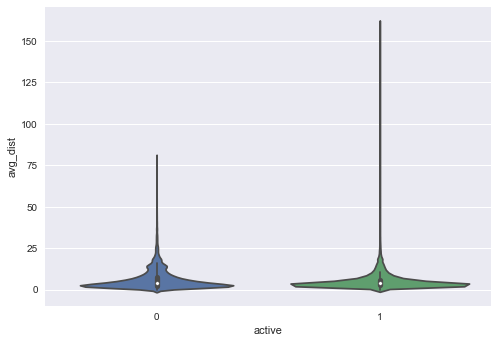

In [34]:
sns.violinplot(data=df,x='active',y='avg_dist')

Note: There is a major difference between active verse inactive user in average distance

(3.5, 5.2)

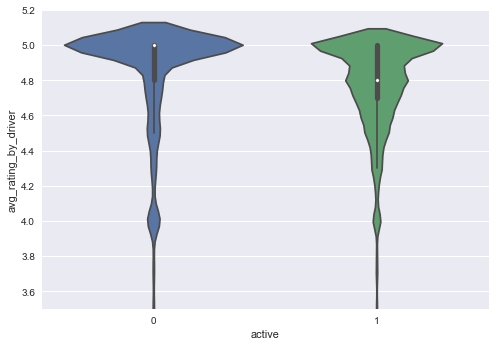

In [35]:
sns.violinplot(data=df,x='active',y='avg_rating_by_driver')
plt.ylim([3.5,5.2])

Note: Active users have a slightly lower rating than inactive users

### Feature Modeling

Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key


In [36]:
df[["active"]].value_counts()

active
0         30933
1         18671
dtype: int64

Note: 49604 entries with 18,671 active users at the end of the six month period

In [37]:
df.active.value_counts(normalize=True)*100

0    62.35989
1    37.64011
Name: active, dtype: float64

Note: 37.6% of users are active at the end of the six month period

### Build Predictive Model

The predictive model of choose will be Random forest algorithm because it can first be used for both classifications and regression task and secondly, it usually provides higher accuracy through cross validation.

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression

#### Standard Scaler

In [39]:
#Scale data
scaler = QuantileTransformer()
scaled_features = scaler.fit_transform(df_features)

#### Split the X and y into 75/25 training and testing data subsets

In [40]:
#train test split
X_train, X_test, y_train, y_test= train_test_split(scaled_features, y, test_size=0.25, random_state=42)

### Random Forest

In [47]:
#build random forest model with 1000 estimators
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

In [59]:
print('Random Forest Score: ', rf.score(X_test,y_test))

Random Forest Score:  0.7543746472058704


Note: 75% accuracy with Random Forest

#### Random Forest with Cross_Validation

In [54]:
print(cross_val_score(rf,X_test,np.ravel(y_test),cv=5))
print('Mean Cross Validated Score:',np.mean(cross_val_score(rf,X_test,np.ravel(y_test),cv=5)))

[0.76138654 0.75282258 0.75604839 0.74919355 0.76290323]
Mean Cross Validated Score: 0.7561481452588057


#### Random Forrest - Feature Importance 

In [60]:
df_importance = pd.DataFrame(zip(list(df_features.columns),rf.feature_importances_),index=range(df_features.columns.shape[0]),columns=['feature','importance'])
df_importance.sort_values(by='importance',ascending=False)

,feature,importance
5,avg_dist,0.300934
4,weekday_pct,0.132606
6,avg_rating_by_driver,0.113628
0,trips_in_first_30_days,0.081048
1,avg_rating_of_driver,0.080731
3,surge_pct,0.078938
2,avg_surge,0.065917
8,city_King's Landing,0.047137
11,phone_iPhone,0.020012
10,phone_Android,0.019079


### Logistic Regression

In [55]:
#initialize model
logit = LogisticRegression(solver='lbfgs')
#set parameter grid
param_grid = {'C':np.arange(0.5,5.1,0.1)}
#instantiate and fit grid search object
grid = GridSearchCV(logit,param_grid,cv=5)
grid.fit(X_train,np.ravel(y_train))

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,
       3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,
       4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ])})

In [56]:
grid.best_estimator_.C

4.1

In [ ]:
Note: logistic regression model with some hyper parameter tuning

#### Logistic Regression with Cross_Validation

In [58]:
print(np.mean(cross_val_score(grid,X_test,np.ravel(y_test),cv=5)))

0.7471175774596611


#### Logistic Regression - Feature Importance with coeffient

In [61]:
#find coefficients from Logistic Regression
logit_coef = LogisticRegression(C=grid.best_estimator_.C)
logit_coef.fit(X_train,y_train)
df_coef = pd.DataFrame(zip(list(df_features.columns),logit_coef.coef_[0]),index=range(df_features.columns.shape[0]),columns=['feature','coefficient'])
df_coef

,feature,coefficient
0,trips_in_first_30_days,0.090396
1,avg_rating_of_driver,-0.467817
2,avg_surge,2.411344
3,surge_pct,-1.350913
4,weekday_pct,-0.255000
5,avg_dist,0.147504
6,avg_rating_by_driver,-1.321206
7,city_Astapor,-0.753967
8,city_King's Landing,1.129336
9,city_Winterfell,-0.239836


In conclusion:
    There was no best-performing Model. Both models perform the same with a 75% accuracy for use for future prediction.  Taking the three most essential features, we can see the following effects on the "activity" of a rider after six months. Average distance: was different with both models. The Random Forrest Model had 30% while the regression model was reading 15%. The logistic regression model shows lower increase in average distance per trip in the first 30 days. 